In [258]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
from bs4 import BeautifulSoup 

# import planning area

<class 'geopandas.geodataframe.GeoDataFrame'>


,Name,Description,geometry,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.93208 1.30555 0, 103.93208 1.3...",BEDOK,BD,N,EAST REGION,ER,5F00E6FF084F3364,20191223152014
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.72042 1.32824 0, 103.72003 1.3...",BOON LAY,BL,N,WEST REGION,WR,C96AED188C00B2FC,20191223152014
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.76408 1.37001 0, 103.76444 1.3...",BUKIT BATOK,BK,N,WEST REGION,WR,3BEC4C829160F28A,20191223152014
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82361 1.26018 0, 103.82362 1.2...",BUKIT MERAH,BM,N,CENTRAL REGION,CR,4850795BB0B6A4F7,20191223152014
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.77445 1.39029 0, 103.77499 1.3...",BUKIT PANJANG,BP,N,WEST REGION,WR,656F87D23D6DAB02,20191223152014


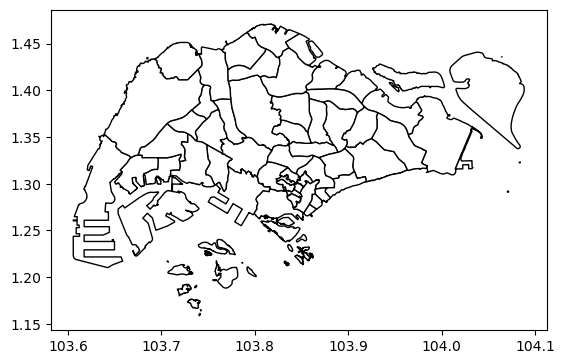

In [259]:

planningArea_noSea = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")

def extract_html_tags(row):
    html_content = row["Description"]
    soup = BeautifulSoup(html_content,"html.parser")
    ths = soup.find_all('th')
    tds = soup.find_all('td')
    column_names = []
    column_values = []
    for th in ths:
        column_names.append(th.get_text())
    for td in tds:
        column_values.append(td.get_text())
    column_names = column_names[1:] # remove the first "Attribute"
    return pd.Series({k:v for k,v in zip(column_names,column_values)})
# column_names, _ = extract_html_tags(planningArea_noSea.iloc[0,1])
planningArea_shp = planningArea_noSea.join(planningArea_noSea.apply(extract_html_tags,axis=1))
print(type(planningArea_shp))
planningArea_shp.plot(fc='white',ec='k')
planningArea_shp.head()

# Import filepaths

In [260]:
save_dir = r"HRI_analysis\data"
data_fps = {fp.replace(".csv","").replace("planningArea","").replace("_",""): os.path.join(save_dir,d,fp) for d in os.listdir(save_dir) for fp in os.listdir(os.path.join(save_dir,d)) if (fp.endswith('.csv') and 'planningArea' in fp and not bool(re.search("NDVI|minMax",fp)))}
data_fps = {k: data_fps[k] for k in list(data_fps)[:-2]}
data_fps

{'Clinic': 'HRI_analysis\\data\\demographic_data\\Clinic_planningArea.csv',
 'Greenspaces': 'HRI_analysis\\data\\demographic_data\\Greenspaces_planningArea.csv',
 'IncomeQuintile': 'HRI_analysis\\data\\demographic_data\\IncomeQuintile_planningArea.csv',
 'NonACHouseholds': 'HRI_analysis\\data\\demographic_data\\NonACHouseholds_planningArea.csv',
 'PopulationDensityAge': 'HRI_analysis\\data\\demographic_data\\Population_Density_Age_planningArea.csv',
 'Schools': 'HRI_analysis\\data\\demographic_data\\Schools_planningArea.csv',
 'Workplace': 'HRI_analysis\\data\\demographic_data\\Workplace_planningArea.csv',
 'Landsat 8 Daytime LST May 2018': 'HRI_analysis\\data\\LST\\Landsat 8 Daytime LST May 2018_planningArea.csv',
 'MODIS nighttime LST 2018050916': 'HRI_analysis\\data\\LST\\MODIS nighttime LST 2018050916_planningArea.csv',
 'SGserviceArea': 'HRI_analysis\\data\\Public_transit_Service_Area\\SG_serviceArea_planningArea.csv',
 'minMeantravelTimeHospital': 'HRI_analysis\\data\\serviceArea

# Read csvs

In [262]:
# read dfs
dfs = {fp_name: pd.read_csv(fp) for fp_name,fp in data_fps.items()}
# rename planning area column
dfs = {df_name: df.rename(columns = lambda x: 'PLN_AREA_N' if 'PLN_AREA_N' in x else x) for df_name,df in dfs.items()}
dfs

{'Clinic':     Clinic_Count  TARGET_FID    Name               PLN_AREA_N PLN_AREA_C  \
 0             82           1   kml_1                    BEDOK         BD   
 1              2           2   kml_2                 BOON LAY         BL   
 2             42           3   kml_3              BUKIT BATOK         BK   
 3             63           4   kml_4              BUKIT MERAH         BM   
 4             22           5   kml_5            BUKIT PANJANG         BP   
 5             28           6   kml_6              BUKIT TIMAH         BT   
 6             12           7   kml_8                   CHANGI         CH   
 7             25           8   kml_9            CHOA CHU KANG         CK   
 8             32           9  kml_10                 CLEMENTI         CL   
 9             61          10  kml_11                  HOUGANG         HG   
 10            32          11  kml_12              JURONG EAST         JE   
 11            43          12  kml_13              JURONG WEST    

In [264]:
# change service area to inaccessibility to service area
dfs['SGserviceArea']['InaccessibilityPublicTransit'] = dfs['SGserviceArea']['SA_PA_ratio'].apply(lambda x: 1-x)
# rename other columns
dfs_columns = [df.columns for df in dfs.values()]
dfs_columns[3]
dfs['SGserviceArea'].head()

,PLN_AREA_N,PLN_AREA_C,serviceArea_km2,planningArea_km2,SA_PA_ratio,InaccessibilityPublicTransit
0,BEDOK,BD,6.687217,21.733905,0.307686,0.692314
1,BUKIT MERAH,BM,4.190238,14.461198,0.289757,0.710243
2,JURONG EAST,JE,2.810782,17.860003,0.157379,0.842621
3,BOON LAY,BL,0.843824,8.282764,0.101877,0.898123
4,BUKIT BATOK,BK,3.031423,11.140156,0.272117,0.727883


# Rename df columns

In [276]:
dfs_columns = [{'Clinic/pop':'clinic_per_pop'},
                {'Intersect_Statistics.SUM_ParkArea': 'park_area'},
                {'Q1':'IncomeQ1', 'Q2':'IncomeQ2', 'Q3':'IncomeQ3', 'Q4':'IncomeQ4', 'Q5':'IncomeQ5'},
                {'Total':'NonAirconPop'},
                {'PopulationDensity':'PopulationDensity','PopulationDensity_VulGroup':'vulGroup_per_popDensity'},
                {'Total':'student_pop'},
                {'EmployedResidents_PlanningAreaofWork.csv.Total': 'working_pop'},
                {'MAX': 'LST_Landsat_max'},
                {'MAX': 'LST_MODIS_max'},
                {'InaccessibilityPublicTransit': 'InaccessibilityPublicTransit'},
                {'min_travel_time': 'hospitalTravelTime'},
                ]
dfs_filtered_columns = [df.loc[:,['PLN_AREA_N']+list(cols)].rename(columns=cols) for df,cols in zip(dfs.values(),dfs_columns)]
dfs_filtered_columns[2]

,PLN_AREA_N,IncomeQ1,IncomeQ2,IncomeQ3,IncomeQ4,IncomeQ5
0,BEDOK,17680,16451,17474,15701,26395
1,BOON LAY,0,0,0,0,0
2,BUKIT BATOK,9568,10186,11392,10313,11835
3,BUKIT MERAH,13769,8962,9620,10334,13701
4,BUKIT PANJANG,6499,8332,10076,8571,9402
5,BUKIT TIMAH,1465,1653,2587,3335,14916
6,CHANGI,0,0,0,0,0
7,CHOA CHU KANG,7617,10124,13975,13359,12385
8,CLEMENTI,5454,5273,5918,5917,9702
9,HOUGANG,13221,13480,16228,14487,16249


# Merge dataframe by planning area

In [277]:
# merge all dfs_filtered_columns by PLN_AREA_N
from functools import reduce
HRI_df = reduce(lambda x, y: pd.merge(x, y, on = 'PLN_AREA_N'), dfs_filtered_columns)
HRI_df.head()

,PLN_AREA_N,clinic_per_pop,park_area,IncomeQ1,IncomeQ2,IncomeQ3,IncomeQ4,IncomeQ5,NonAirconPop,PopulationDensity,vulGroup_per_popDensity,student_pop,working_pop,LST_Landsat_max,LST_MODIS_max,InaccessibilityPublicTransit,hospitalTravelTime
0,BEDOK,0.000296,1.547828,17680,16451,17474,15701,26395,19803,12744.603300,5029.928998,30118,59875.0,54.631256,27.529999,0.692314,322.324601
1,BOON LAY,0.050000,NaN,0,0,0,0,0,0,4.829306,0.000000,0,19300.0,58.358612,27.649994,0.898123,384.201006
2,BUKIT BATOK,0.000266,0.948556,9568,10186,11392,10313,11835,11022,14185.618000,5013.394705,13481,33792.0,51.298691,26.589996,0.727883,229.263267
3,BUKIT MERAH,0.000417,1.316436,13769,8962,9620,10334,13701,12119,10459.022770,4393.135318,10818,103575.0,55.371246,27.450012,0.710243,166.557026
4,BUKIT PANJANG,0.000159,3.457346,6499,8332,10076,8571,9402,8847,15329.387900,5381.416710,13722,9091.0,49.034241,26.290009,0.748119,418.432936


In [278]:
df_missing_planning_area = [', '.join(list(set(planningArea_shp['PLN_AREA_N'])^set(df['PLN_AREA_N']))) for df in dfs.values()]
print(df_missing_planning_area)
list(data_fps)[-3]

['WESTERN ISLANDS, NORTH-EASTERN ISLANDS', '', 'WESTERN ISLANDS, NORTH-EASTERN ISLANDS, SOUTHERN ISLANDS', 'WESTERN ISLANDS, NORTH-EASTERN ISLANDS, SOUTHERN ISLANDS', 'WESTERN ISLANDS, NORTH-EASTERN ISLANDS', '', 'NORTH-EASTERN ISLANDS', '', 'SINGAPORE RIVER, STRAITS VIEW', 'WESTERN ISLANDS, NORTH-EASTERN ISLANDS, SOUTHERN ISLANDS', 'WESTERN ISLANDS, NORTH-EASTERN ISLANDS']


'MODIS nighttime LST 2018050916'

23    NORTH-EASTERN ISLANDS
26         SOUTHERN ISLANDS
30          WESTERN ISLANDS
35          SINGAPORE RIVER
36             STRAITS VIEW
Name: PLN_AREA_N, dtype: object


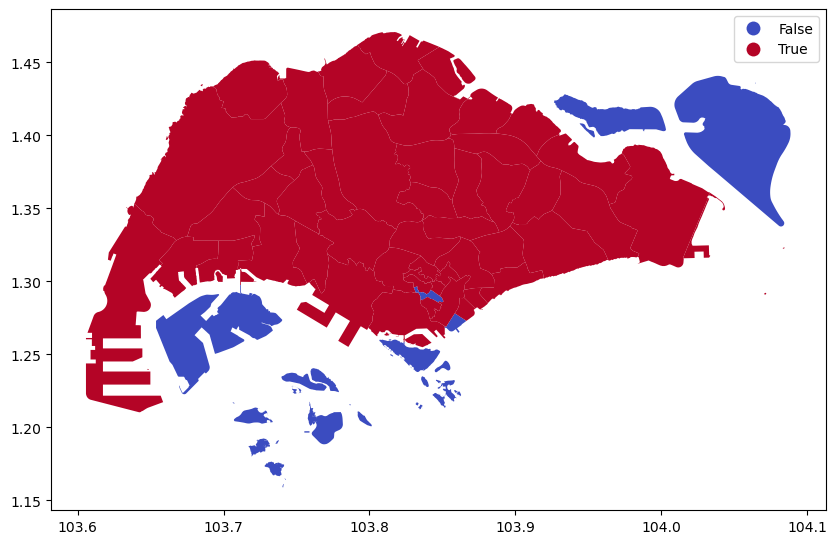

In [279]:
# add a column for planningArea that matches the planningArea_shp
planningArea_shp['valid_areas'] = planningArea_shp['PLN_AREA_N'].isin(HRI_df['PLN_AREA_N'].to_list())
print(planningArea_shp[~planningArea_shp['PLN_AREA_N'].isin(HRI_df['PLN_AREA_N'])]['PLN_AREA_N'])
ax = planningArea_shp.plot(column='valid_areas', cmap='coolwarm', legend=True, figsize=(10, 10))

# Calculate correlation between variables

In [280]:
# remove the first column (PLN_AREA_N) for correlation matrix
corr_matrix = HRI_df.iloc[:,1:].corr()
corr_matrix

,clinic_per_pop,park_area,IncomeQ1,IncomeQ2,IncomeQ3,IncomeQ4,IncomeQ5,NonAirconPop,PopulationDensity,vulGroup_per_popDensity,student_pop,working_pop,LST_Landsat_max,LST_MODIS_max,InaccessibilityPublicTransit,hospitalTravelTime
clinic_per_pop,1.000000,-0.084554,-0.337787,-0.330873,-0.329618,-0.336389,-0.374277,-0.363550,-0.463684,-0.403269,-0.313734,-0.015034,0.115140,0.042333,0.126051,0.227386
park_area,-0.084554,1.000000,-0.127787,-0.125696,-0.126747,-0.130457,-0.142857,-0.144253,0.053546,-0.193590,-0.123948,-0.064167,-0.202195,-0.340600,0.260366,0.290180
IncomeQ1,-0.337787,-0.127787,1.000000,0.965344,0.933976,0.920052,0.866258,0.965049,0.720976,0.759696,0.786950,0.094410,0.325049,0.265938,-0.134145,-0.279872
IncomeQ2,-0.330873,-0.125696,0.965344,1.000000,0.991543,0.975782,0.858165,0.976929,0.772559,0.778945,0.813821,0.009798,0.295860,0.217137,-0.112416,-0.249716
IncomeQ3,-0.329618,-0.126747,0.933976,0.991543,1.000000,0.993045,0.862130,0.970625,0.804909,0.799005,0.810523,-0.027025,0.271670,0.214843,-0.117089,-0.246671
IncomeQ4,-0.336389,-0.130457,0.920052,0.975782,0.993045,1.000000,0.886084,0.968155,0.813367,0.808936,0.805338,-0.027725,0.262797,0.245063,-0.124919,-0.269435
IncomeQ5,-0.374277,-0.142857,0.866258,0.858165,0.862130,0.886084,1.000000,0.909767,0.710005,0.751719,0.796128,-0.017117,0.259438,0.283270,-0.118520,-0.282310
NonAirconPop,-0.363550,-0.144253,0.965049,0.976929,0.970625,0.968155,0.909767,1.000000,0.802254,0.819608,0.830524,0.049927,0.301326,0.273327,-0.149057,-0.275381
PopulationDensity,-0.463684,0.053546,0.720976,0.772559,0.804909,0.813367,0.710005,0.802254,1.000000,0.989034,0.640091,-0.125987,-0.112552,0.092588,-0.339189,-0.257702
vulGroup_per_popDensity,-0.403269,-0.193590,0.759696,0.778945,0.799005,0.808936,0.751719,0.819608,0.989034,1.000000,0.658831,-0.106380,0.090899,0.218323,-0.435045,-0.338977


C:\Users\hypak\AppData\Local\Temp\ipykernel_14924\337735431.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, 10) # jet doesn't have white color
C:\Users\hypak\AppData\Local\Temp\ipykernel_14924\337735431.py:27: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  text = ax.text(j, i, f"{corr_array[i, j]:.3f}",


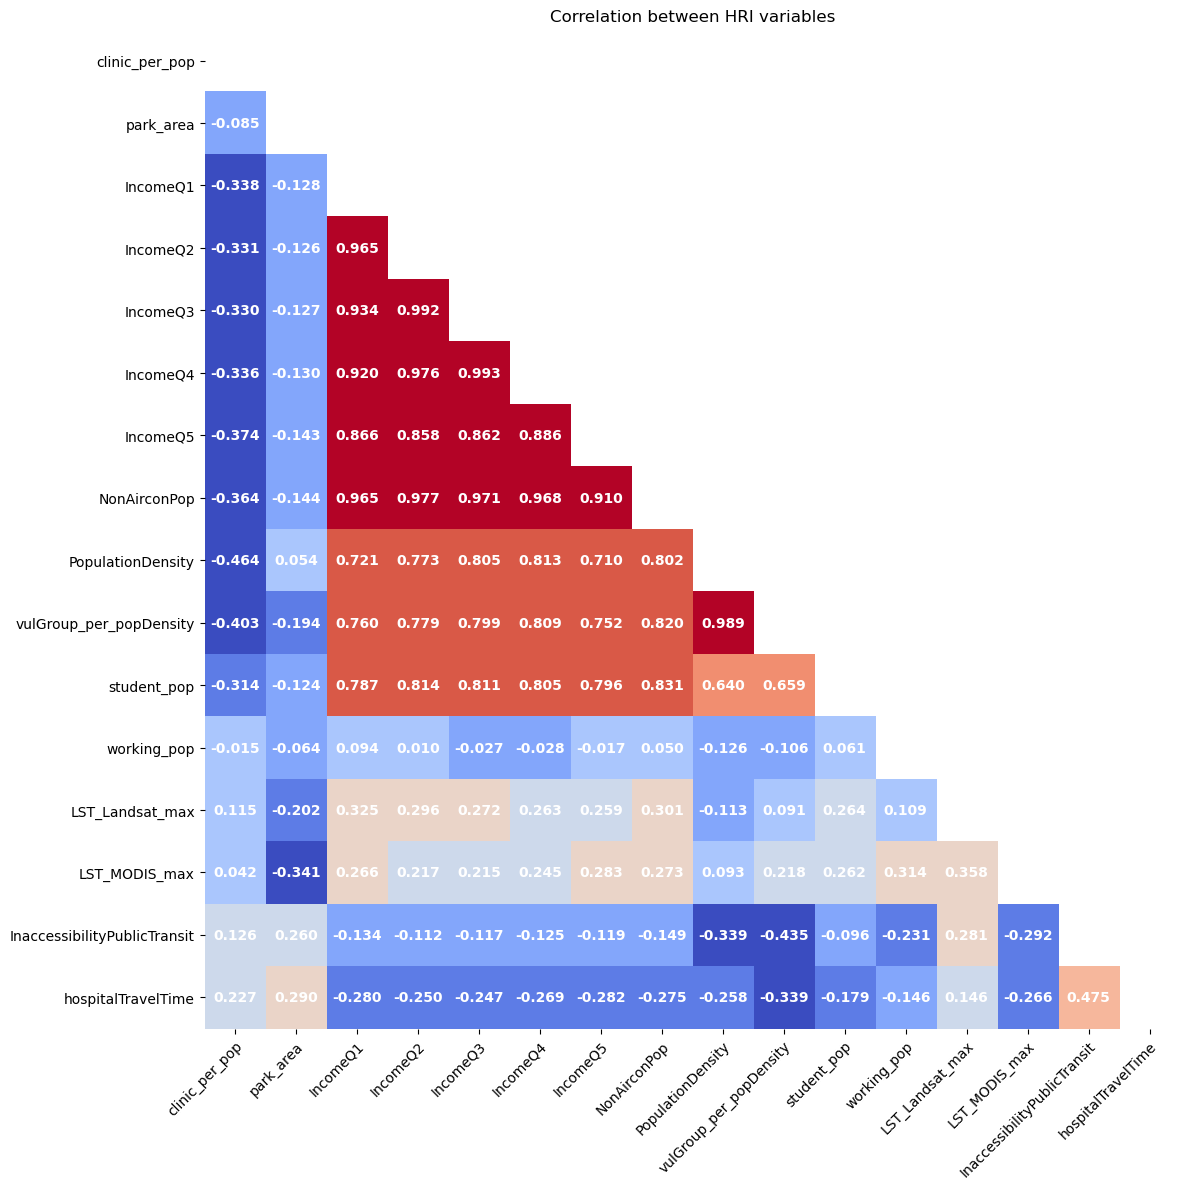

In [281]:
def correlation_plot(corr_matrix, title='Correlation Matrix',cmap='coolwarm'):
    """
    Plot the correlation matrix using seaborn heatmap.
    """
    corr_array = corr_matrix.values
    # mask out lower triangle
    # mask =  np.tri(corr_array.shape[0], k=-1)
    mask =  np.triu(corr_array, k=0)
    corr_array = np.ma.array(corr_array, mask=mask)
    # set cmap
    cmap = cm.get_cmap(cmap, 10) # jet doesn't have white color
    cmap.set_bad('w') # default value is 'k'
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(corr_array,cmap=cmap, aspect='auto')

    xlabels = corr_matrix.columns
    ylabels = corr_matrix.index

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(xlabels)), labels=xlabels,
                rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(ylabels)), labels=ylabels)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ylabels)):
        for j in range(len(xlabels)):
            text = ax.text(j, i, f"{corr_array[i, j]:.3f}", 
                        ha="center", va="center", color="w",fontweight='bold')
    ax.spines[:].set_visible(False)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

correlation_plot(corr_matrix, title='Correlation between HRI variables',cmap='coolwarm')
# plt.figure(figsize=(8, 6))  # Adjust figure size as needed
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title('Correlation Matrix')
# plt.show()

# PCA analysis

Under Eigen-Vectors, we can say that Principal components show both common and unique variance of the variable. Basically, it is variance focused approach seeking to reproduce total variance and correlation with all components. The principal components are basically the linear combinations of the original variables weighted by their contribution to explain the variance in a particular orthogonal dimension.

## Eigen Values
It is basically known as characteristic roots. It basically measures the variance in all variables which is accounted for by that factor. The ratio of eigenvalues is the ratio of explanatory importance of the factors with respect to the variables. If the factor is low then it is contributing less to the explanation of variables. In simple words, it measures the amount of variance in the total given database accounted by the factor. We can calculate the factor's eigenvalue as the sum of its squared factor loading for all the variables.

In [282]:
from sklearn.preprocessing import StandardScaler

### HRI_dfs
- Drop rows with NAs
- imputation with 0

In [283]:
nas_summary = {col: {"n_NAs": HRI_df[col].isna().sum(), "PLN_AREA_N": HRI_df.loc[HRI_df[col].isna(), 'PLN_AREA_N'].values} for col in HRI_df.iloc[:,1:].columns}
nas_summary = [{'variable':var, 'n_NAs': var_summary['n_NAs'], 'PLN_AREA': ', '.join(sorted(list(var_summary['PLN_AREA_N'])) )} for var, var_summary in nas_summary.items() if var_summary['n_NAs'] > 0]
nas_summary = pd.DataFrame(nas_summary)
save_dir = r"data"
nas_summary.to_csv(os.path.join(save_dir, 'HRI_NAs_summary.csv'), index=False)
nas_summary

,variable,n_NAs,PLN_AREA
0,park_area,9,"BOON LAY, CHANGI BAY, MARINA SOUTH, PAYA LEBAR..."
1,PopulationDensity,5,"CENTRAL WATER CATCHMENT, CHANGI BAY, MARINA EA..."
2,working_pop,9,"CENTRAL WATER CATCHMENT, CHANGI BAY, LIM CHU K..."
3,InaccessibilityPublicTransit,1,MARINA EAST


In [285]:
# remove rows with NAs
print("NAs in HRI_df:", HRI_df.isna().sum())
HRI_df_noNAs = HRI_df.dropna()
print("length of HRI_df_noNAs:", len(HRI_df_noNAs))
HRI_df_noNAs.head()

# imput NAs with 0
HRI_imputed = HRI_df.fillna(0)
print("length of HRI_imputed:", len(HRI_imputed))
HRI_imputed.head()

HRI_dfs = {'noNAs': HRI_df_noNAs,
            'imputed': HRI_imputed}

NAs in HRI_df: PLN_AREA_N                      0
clinic_per_pop                  0
park_area                       9
IncomeQ1                        0
IncomeQ2                        0
IncomeQ3                        0
IncomeQ4                        0
IncomeQ5                        0
NonAirconPop                    0
PopulationDensity               5
vulGroup_per_popDensity         0
student_pop                     0
working_pop                     9
LST_Landsat_max                 0
LST_MODIS_max                   0
InaccessibilityPublicTransit    1
hospitalTravelTime              0
dtype: int64
length of HRI_df_noNAs: 36
length of HRI_imputed: 50


In [286]:
from sklearn.decomposition import PCA

pca_results = dict()
for df_type, df in HRI_dfs.items():
    sc = StandardScaler()
    HRI_standardized = sc.fit_transform(df.iloc[:,1:])  # Exclude PLN_AREA_N for scaling
    pca = PCA(n_components=None)
    HRI_PCA = pca.fit(HRI_standardized)
    # Percentage of variance explained by each of the selected components. 
    # The values are sorted by decreasing explained_variance_, thus it doesnt directly correspond to the order of the original features.
    var = pca.explained_variance_ratio_
    # features contribute to principal components through the loadings (i.e. coefficients of the linear combination of the original features that form the principal components).
    # components_ tells us how strongly each original feature correlates with each PC
    loadings = pca.components_
    # Create a DataFrame for loadings with original feature names, display the loadings for each principal component
    # look at the absolute values in each row, the large the absolute value, the more influence that feature has on that PC
    # each row in loadings_df correspond to a principal component, and each column corresponds to an original feature. The values indicate how much each feature contributes to that PC
    # e.g. the first row corresponds to the first principal component, and the values in that row indicate how much each original feature contributes to that PC
    loadings_df = pd.DataFrame(loadings, columns=df.columns[1:])
    pca_results[df_type] = {'explained_variance': var,'loadings_df': loadings_df}

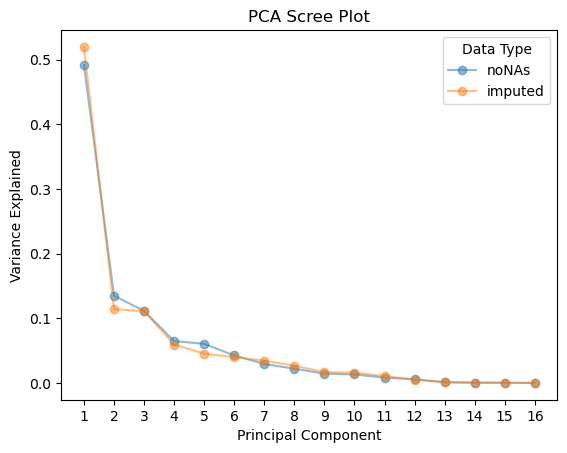

In [287]:
# plot scree plot of the first principal components
def scree_plot(explained_variance, title='Scree Plot',label=None,ax=None):
    """
    Plot the scree plot of the PCA results.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label=label,alpha=0.5)
    
    ax.set_title(title)
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Variance Explained')
    ax.set_xticks(range(1, len(explained_variance) + 1))
    # plt.legend()
    if ax is None:
        plt.show()
    return ax

fig, ax = plt.subplots()
for df_type in pca_results.keys():
    ax = scree_plot(pca_results[df_type]['explained_variance'], title=f'PCA Scree Plot', ax=ax,label=df_type)
# plot legend from handles
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, loc='upper right', title='Data Type')
plt.show()

In [289]:
pca_results['imputed']['loadings_df'].iloc[[0],:].abs().melt(value_name="PCA absolute loadings").sort_values(by='PCA absolute loadings',ascending=False)

,variable,PCA absolute loadings
7,NonAirconPop,0.341066
5,IncomeQ4,0.336004
4,IncomeQ3,0.335085
3,IncomeQ2,0.334686
2,IncomeQ1,0.328914
6,IncomeQ5,0.316945
8,PopulationDensity,0.303963
9,vulGroup_per_popDensity,0.303892
10,student_pop,0.294458
0,clinic_per_pop,0.141813
